In [1]:
from google.cloud import storage
from PIL import Image
import numpy as np
import hashlib
import os
import sys
import torch
import io
import cv2

import torch

# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.tf_record_reader as tfrr

NUM_KEYPOINTS = 9

In [11]:
def glob_objectron():
    client = storage.Client.create_anonymous_client()
    blobs = client.list_blobs('objectron',
                              prefix='v1/records_shuffled/cup/cup_train')
    return [blob.name for blob in blobs]

In [12]:
glob_objectron()

['v1/records_shuffled/cup/cup_train-00000-of-00995',
 'v1/records_shuffled/cup/cup_train-00001-of-00995',
 'v1/records_shuffled/cup/cup_train-00002-of-00995',
 'v1/records_shuffled/cup/cup_train-00003-of-00995',
 'v1/records_shuffled/cup/cup_train-00004-of-00995',
 'v1/records_shuffled/cup/cup_train-00005-of-00995',
 'v1/records_shuffled/cup/cup_train-00006-of-00995',
 'v1/records_shuffled/cup/cup_train-00007-of-00995',
 'v1/records_shuffled/cup/cup_train-00008-of-00995',
 'v1/records_shuffled/cup/cup_train-00009-of-00995',
 'v1/records_shuffled/cup/cup_train-00010-of-00995',
 'v1/records_shuffled/cup/cup_train-00011-of-00995',
 'v1/records_shuffled/cup/cup_train-00012-of-00995',
 'v1/records_shuffled/cup/cup_train-00013-of-00995',
 'v1/records_shuffled/cup/cup_train-00014-of-00995',
 'v1/records_shuffled/cup/cup_train-00015-of-00995',
 'v1/records_shuffled/cup/cup_train-00016-of-00995',
 'v1/records_shuffled/cup/cup_train-00017-of-00995',
 'v1/records_shuffled/cup/cup_train-00018-of-0

In [3]:
def decode(example):
  """ Convert TFRecord Entry into torch-compatible format """
  w = example['image/width'].item()
  h = example['image/height'].item()
  points = example['point_2d'].numpy()
  num_instances = example['instance_num'].item()
  points = points.reshape(num_instances, NUM_KEYPOINTS, 3)
  image_data = example['image/encoded'].numpy().tobytes()
  image = Image.open(io.BytesIO(image_data))
  npa = np.asarray(image)
  return torch.from_numpy(npa), points, num_instances


In [4]:
%matplotlib inline
# https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
import matplotlib.pyplot as plt


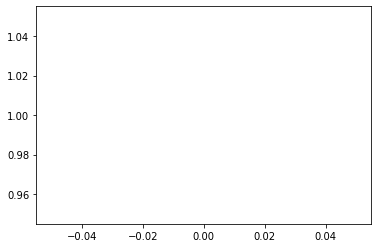

In [5]:
plt.plot([0,0], [1,1])
plt.show()


In [6]:

RADIUS = 10

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (128, 128, 0), (128, 0, 128), 
          (0, 128, 128), (255, 255, 255), (0, 0, 0)]
EDGES = [
  [1, 5], [2, 6], [3, 7], [4, 8],  # lines along x-axis
  [1, 3], [5, 7], [2, 4], [6, 8],  # lines along y-axis
  [1, 2], [3, 4], [5, 6], [7, 8]   # lines along z-axis
]  

def load_dataset():
    r = tfrr.TfRecordReader(path, compression='', transforms=transforms)
    for i in range(num_samples):
        example = r.read_example()
        img_tensor, keypoints, num_instances = decode(example)


def show_3d_bounding_box(path, num_samples):
  count = 0
  transforms = {}  
  r = tfrr.TfRecordReader(path, compression='', transforms=transforms)
  fig, ax = plt.subplots(1, 10, figsize = (12, 16))
  
  for i in range(num_samples):
    example = r.read_example()
    if not example: break
    img_tensor, keypoints, num_instances = decode(example)
    image_clone = img_tensor

    for object_id in range(num_instances):
      w = 480
      h = 640
      for kp_id in range(NUM_KEYPOINTS):
        kp_pixel = keypoints[object_id, kp_id, :]
        cv2.circle(image_clone.numpy(), (int(w  * kp_pixel[0]), int(h * kp_pixel[1])), 
                  RADIUS, colors[object_id % len(colors)], -1)
      for edge in EDGES:
        start_kp = keypoints[object_id, edge[0], :]
        start_x = int(w * start_kp[0])
        start_y = int(h * start_kp[1])
        
        end_kp = keypoints[object_id, edge[1], :]
        end_x = int(w * end_kp[0])
        end_y = int(h * end_kp[1])

        cv2.line(image_clone.numpy(), (start_x, start_y), (end_x, end_y), 
                  colors[object_id % len(colors)], 1)
    ax[i].grid(False)
    ax[i].imshow(image_clone);
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

  fig.tight_layout();
  plt.show()

gs://objectron/v1/records_shuffled/cup/cup_train-00000-of-00995


/home/jamiecho/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  # This is added back by InteractiveShellApp.init_path()


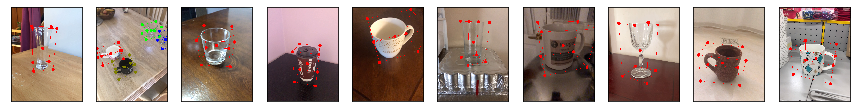

gs://objectron/v1/records_shuffled/cup/cup_train-00001-of-00995


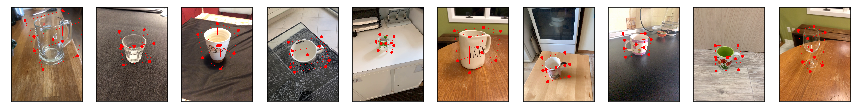

gs://objectron/v1/records_shuffled/cup/cup_train-00002-of-00995


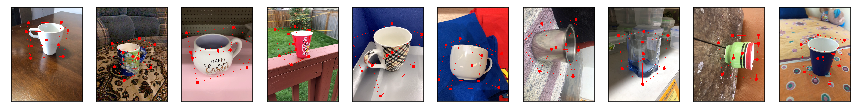

gs://objectron/v1/records_shuffled/cup/cup_train-00003-of-00995


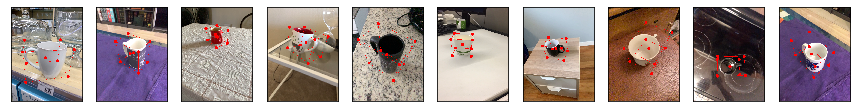

gs://objectron/v1/records_shuffled/cup/cup_train-00004-of-00995


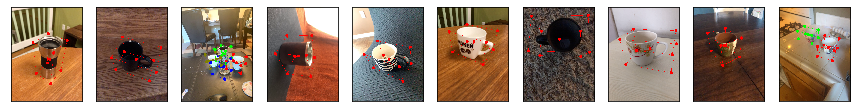

In [16]:
training_shards = glob_objectron()
for i in range(5):
  shard_name = 'gs://objectron/' + training_shards[i]
  print(shard_name)
  # Visualize the bounding box on the first 10 sample from this shard.
  show_3d_bounding_box(path = shard_name, num_samples = 10)